# **Assignment 3 Part A**
An MLP consists of at least three layers of nodes: an input layer, a hidden layer and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training.Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable

## **Using pure Numpy to build a 3 layer neural network with relu as non-linear activation function**

t-SNE is an unsupervised topology learning algorithm that is able to find the low-dimensional manyfolds in the original high-dimensional space, and to project these manyfolds in a destination space of much lower dimension, typically 2D or 3D

In [1]:
##Importing required libraries
import numpy as np

In [2]:
##Initializing values for weights
a = np.array([[1,2,3], [4,5,6]])
print(a)

[[1 2 3]
 [4 5 6]]


In [3]:
##Initializing values for bias
bias = np.array([[1],[0.5]])
print(bias)

[[1. ]
 [0.5]]


In [4]:
##Generating 3d input data and calculating y_true value
n = 500
d = 3
x = np.random.uniform(-1, 1, (n, d))
a = a.T
## y1 = x_1^2 + 2 * x_2^2 + 3 * x_3^2 + x_1 + 2 * x_2 + 3 * x_3 + 1
## y2 = 4 * x_1^2 + 5 * x_2^2 + 6 * x_3^2 + 4 * x_1 + 5 * x_2 + 6 * x_3 + 0.5
##Calculating actual output for the data
y_true = (x ** 2) @ a + x @ a + bias.T
print(f'x: {x.shape}, weights: {a.shape}, bias: {bias.shape}, y: {y_true.shape}')

x: (500, 3), weights: (3, 2), bias: (2, 1), y: (500, 2)


In [5]:
##Visualizing the data distribution using TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_jobs=5).fit_transform(x)
tsne.shape

(500, 2)

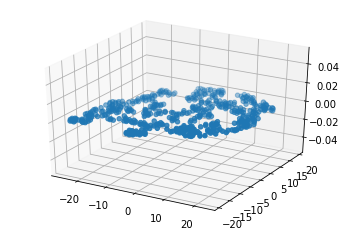

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*zip(*tsne))
plt.show()

In [7]:
##Calculating gradient wrt loss
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    # print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

In [8]:
##Forward and backward prop
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

In [9]:
##Adding relu activation function
class Relu:
    def __call__(self, input_):
        self.input_ = input_
        self.output = np.clip(self.input_, 0, None)
        return self.output
    
    def backward(self, output_gradient):
      self.input_gradient = (self.input_ > 0) * output_gradient
      return self.input_gradient

In [10]:
##Defining Model layer for the 3 layer neural net
class Model:
  def __init__(self, input_dim, num_hidden):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu = Relu()
    self.linear2 = Linear(num_hidden, 2)
  
  def __call__(self, x):
    l1 = self.linear1(x)
    r = self.relu(l1)
    l2 = self.linear2(r)
    return l2
  
  def backward(self, output_gradient):
    linear2_gradient = self.linear2.backward(output_gradient)
    relu_gradient = self.relu.backward(linear2_gradient)
    linear1_gradient = self.linear1.backward(relu_gradient)
    return linear1_gradient

  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

loss = MSE()

##Calculating and printing initial loss value
model = Model(d, 4)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
l1_gradient = model.backward(loss_gradient)

31.91280140274042


In [13]:
def tsne_plot(x, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(tsne[:, 0], tsne[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(tsne[:, 0], tsne[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

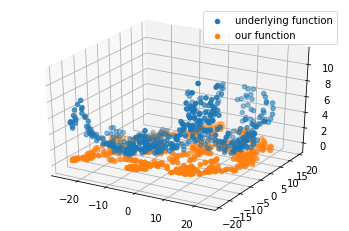

In [14]:
tsne_plot(x, y_true, model(x))

In [15]:
def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y[:, 0], label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

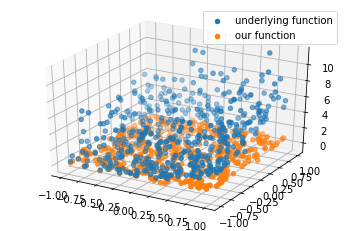

In [16]:
plot_3d(x, y_true, model(x))

In [17]:
# Test just one forward and backward step
loss = MSE()
model = Model(d, 3)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)
loss_gradient = loss.backward()
model.backward(loss_gradient)
model.update(0.1)
y_pred = model(x)
loss_value = loss(y_pred, y_true)
print(loss_value)

40.269606958104866
21.846573576345108


In [18]:
##Custom training loop
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)


In [19]:
fit(x, y_true, model=model, loss=loss, lr=0.1, num_epochs=40)

Epoch 0, loss 21.846573576345108
Epoch 1, loss 8.841361927558946
Epoch 2, loss 5.855955337343773
Epoch 3, loss 5.235058365253836
Epoch 4, loss 5.024147320834546
Epoch 5, loss 6.546509244700534
Epoch 6, loss 5.5943313291927135
Epoch 7, loss 8.549413829677126
Epoch 8, loss 5.15279538189632
Epoch 9, loss 7.461698510861712
Epoch 10, loss 4.768649142747428
Epoch 11, loss 6.699920143546995
Epoch 12, loss 4.52943112470444
Epoch 13, loss 6.2903210197320245
Epoch 14, loss 4.308771408416944
Epoch 15, loss 5.9799348805144055
Epoch 16, loss 4.136681014486553
Epoch 17, loss 5.791673315085044
Epoch 18, loss 3.9006244023117267
Epoch 19, loss 5.431088166766877
Epoch 20, loss 3.7306751925154664
Epoch 21, loss 5.238981317996247
Epoch 22, loss 3.6541645301792642
Epoch 23, loss 5.242753493965923
Epoch 24, loss 3.5815647695128474
Epoch 25, loss 5.205029229735844
Epoch 26, loss 3.4107118879414333
Epoch 27, loss 4.938833227182292
Epoch 28, loss 3.2932219510674505
Epoch 29, loss 4.817218178886542
Epoch 30, lo

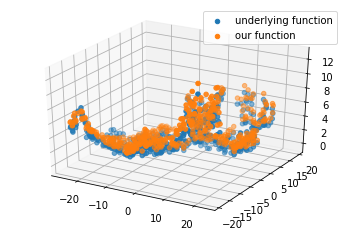

In [20]:
##tsne visualization after training
tsne_plot(x, y_true, model(x))

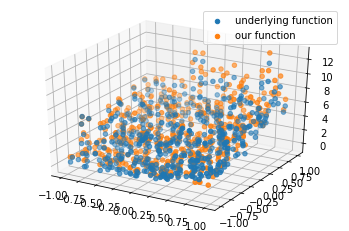

In [21]:
##visualization after training
plot_3d(x, y_true, model(x))